## dataset functions

In [1]:
# dataset = "kelly"
# from kelly_gambling import *

# dataset = "cvar"
# from cvar_stock_option import *

# dataset = "exp_density"
# from exp_density_polynomial import *

dataset = "news_vendor"
from news_vendor import *

device = cpu


## osmm

In [2]:
from osmm import OSMM
osmm_prob = OSMM(f_torch=my_f_torch, g_cvxpy=my_g_cvxpy)

## generate random data

In [3]:
W = generate_random_data()
if dataset != "kelly" and dataset != "exp_density":
    W_validation = generate_random_data()
else:
    W_validation = None
init_val = get_initial_val()

In [4]:
osmm_prob.f_torch.W = W
osmm_prob.f_torch.W_validate = W_validation

## solve

In [5]:
result = osmm_prob.solve(init_val, verbose=True)

iter = 10, objf = -2.285e+00, lower bound = -2.319e+00, RMS residual = 3.180e-02, sampling acc = 1.910e-03, ||G||_F = 1.972e+01
iter = 20, objf = -2.292e+00, lower bound = -2.294e+00, RMS residual = 1.358e-02, sampling acc = 4.482e-03, ||G||_F = 8.797e+02
      Terminated. Num iterations = 20, objf = -2.292e+00, lower bound = -2.294e+00, RMS residual = 1.358e-02, sampling acc = 4.482e-03.
      Time elapsed (secs): 1.315543.



In [6]:
print("result =", result)

result = -2.292268991470337


## get results

In [7]:
x_soln = osmm_prob.method_results["soln"]
Xs = osmm_prob.method_results["var_iters"]

In [8]:
max_num_rounds = len(osmm_prob.method_results["objf_iters"])
iters_taken = osmm_prob.method_results["total_iters"]

In [9]:
objfs = np.array(osmm_prob.method_results["objf_iters"])
for i in range(1, iters_taken):
    objfs[i] = np.min(osmm_prob.method_results["objf_iters"][0:i + 1])
objfs[iters_taken::] = objfs[iters_taken]
objf_min = np.min(objfs[0:iters_taken + 1])

In [10]:
objfs_val = np.array(osmm_prob.method_results["objf_validate_iters"])
objfs_val[iters_taken::] = objfs_val[iters_taken]

In [11]:
lower_bounds = np.array(osmm_prob.method_results["lower_bound_iters"])
lower_bounds[iters_taken::] = lower_bounds[iters_taken]

In [12]:
rms_res = np.array(osmm_prob.method_results["rms_res_iters"])
ts = np.array(osmm_prob.method_results["t_iters"])
start_idx = 3
for i in range(start_idx, iters_taken):
    if ts[i] == 1:
        rms_res[i] = min(rms_res[i-1], rms_res[i])#np.min(osmm_prob.method_results["rms_res_iters"][start_idx:i + 1])
    else:
        rms_res[i] = rms_res[i-1]
rms_res[iters_taken::] = rms_res[iters_taken]

In [13]:
time_detail = osmm_prob.method_results["time_detail_iters"]
#print(time_detail[2, 0:osmm_prob.method_results["total_iters"] + 1])
#print(time_detail[3, 0:osmm_prob.method_results["total_iters"] + 1])
#print(np.sum(time_detail[2, 0:osmm_prob.method_results["total_iters"]]) / 
#      osmm_prob.method_results["total_iters"])
#print(osmm_prob.method_results["total_iters"])

## plots

/Users/xinyueshen/Documents/research/osmm/examples/news_vendor.py:196: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  a.stem([i for i in range(1, n - 1)], x_best[0:n - 2], markerfmt=" ", label="Solution")


a 0.07923779866177019
cost =  1.0000000000216298


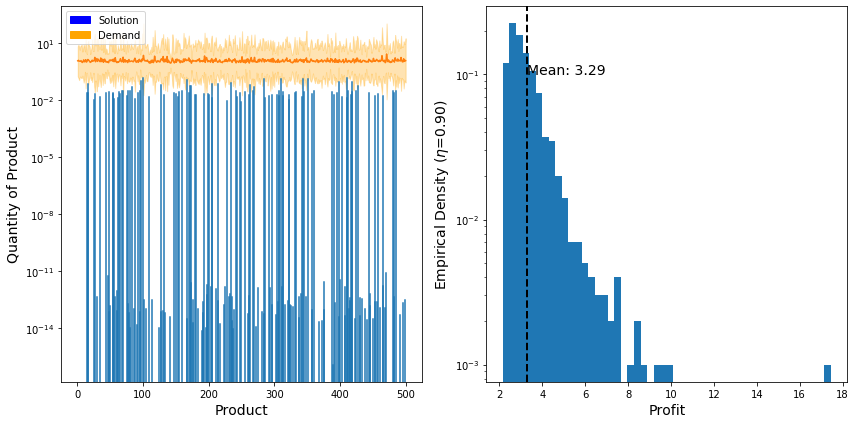

In [14]:
if dataset == "exp_density":
    my_plot_exp_density_one_result(x_soln, objfs, iters_taken, y)
else:
    my_plot_one_result(W, x_soln)

(0, 21)

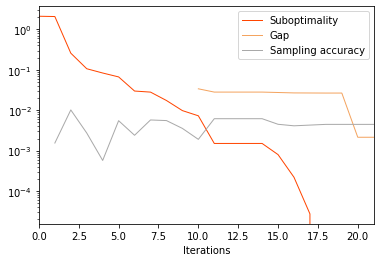

In [15]:
rounds = [i for i in range(0, max_num_rounds)]
f,ax = plt.subplots()

lower_bounds_fixed = [min(lower_bounds[i], np.min(objfs[:])) 
                      for i in range(max_num_rounds)]

ax.plot(rounds, objfs - np.min(objfs), linewidth=1, color="orangered", linestyle="solid", label="Suboptimality")
ax.set_yscale("log")

if np.max(lower_bounds) > -np.inf:
    ax.semilogy(rounds, objfs - lower_bounds_fixed, linewidth=1, color="sandybrown", linestyle="solid", 
                label="Gap")
    
if np.min(objfs_val[1::]) < np.inf:
    ax.semilogy(rounds[1::], np.abs(objfs[1::] - objfs_val[1::]), linewidth=1, color="darkgray", linestyle="solid", 
                label="Sampling accuracy")

ax.legend(loc="upper right")
ax.set_xlabel("Iterations")
plot_iter_lim = iters_taken + 1
ax.set_xlim([0, plot_iter_lim])

(0, 21)

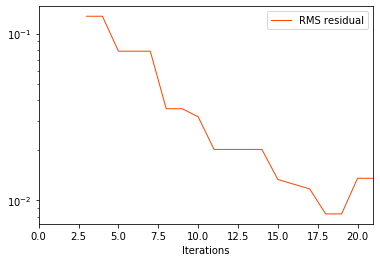

In [16]:
f,ax = plt.subplots()
ax.plot(rounds[start_idx::], rms_res[start_idx::], 
            linewidth=1, color="orangered", linestyle="solid", label="RMS residual")
ax.legend(loc="upper right")
ax.set_xlabel("Iterations")
ax.set_yscale("log")
plot_iter_lim = iters_taken + 1
ax.set_xlim([0, plot_iter_lim])